In [2]:
import os
from osgeo import gdal

import rasterio
from rasterio import windows
from rasterio.windows import Window

from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
#import cv2
import matplotlib.pyplot as plt


In [4]:
#Change the path to your directory
os.chdir('F:\WUR\ACT\GIT Project\TheNavySeals')

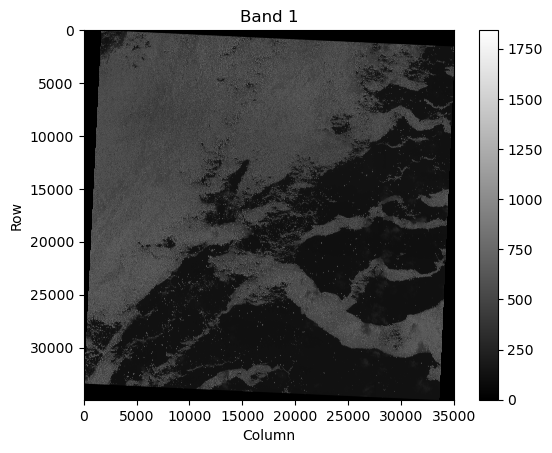

In [5]:
# Open the two rasters
dataset = gdal.Open("data/input/images/22MAR25134903-P3DS-014983717010_01_P001.tif")
band1 = dataset.GetRasterBand(1)
data = band1.ReadAsArray()

geotransform = dataset.GetGeoTransform()
projection = dataset.GetProjection()

plt.imshow(data, cmap='gray')
plt.colorbar()
plt.title('Band 1')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [6]:
# Define the input and output paths for the single image
input_image_path = 'data/input/images/22MAR25134903-P3DS-014983717010_01_P001.tif'
output_image_path = 'data/output/reduced_image.tif'
 
# Function to reduce pixel size from 11 bits to 8 bits for a single image
def reduce_pixel_size(input_path, output_path):
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with rasterio.open(input_path) as src:
        # Read the image as a numpy array
        image_array = src.read(1, masked=True)
        
        # Rescale the pixel values to fit within 8-bit range (0-255)
        scaled_array = (image_array / (2**11 - 1) * 255).astype(np.uint8)
 
        # Create a new raster profile with 8-bit pixel depth
        profile = src.profile
        profile.update(dtype=rasterio.uint8)
 
        # Write the scaled array to a new raster file
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(scaled_array, 1)
 
# Call the function
reduce_pixel_size(input_image_path, output_image_path)
print(f"Reduced image: {input_image_path} -> {output_image_path}")

Reduced image: data/input/images/22MAR25134903-P3DS-014983717010_01_P001.tif -> data/output/reduced_image.tif


In [ ]:
# Get image dimensions
width = dataset.RasterXSize
height = dataset.RasterYSize
# print(f'Image width: {width}, height: {height}')

In [ ]:
# Define the size of each part
part_width = 320
part_height = 320

# Calculate the number of parts
num_parts_x = width // part_width
num_parts_y = height // part_height

In [ ]:
# Create output directory
output_dir = 'output_parts'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
if dataset is not None: 
    print ("band count: " + str(dataset.RasterCount))
bands = dataset.RasterCount

In [ ]:
def split_and_save_image(dataset, part_width, part_height, output_dir):
    # Get image dimensions
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    
    # Calculate the number of parts
    num_parts_x = width // part_width
    num_parts_y = height // part_height

    # Get the number of bands
    bands = dataset.RasterCount

    # Split the image and save
    for i in range(num_parts_x):
        for j in range(num_parts_y):
            x_offset = i * part_width
            y_offset = j * part_height

            # Read the split region
            part = dataset.ReadAsArray(x_offset, y_offset, part_width, part_height)
            
            # Expand dimensions if there's only one band
            if bands == 1:
               part = np.expand_dims(part, axis=0)

            # Create a new GDAL dataset to save the split part
            driver = gdal.GetDriverByName('GTiff')
            output_path = os.path.join(output_dir, f'part_{i}_{j}.tif')
            out_dataset = driver.Create(output_path, part_width, part_height, bands, gdal.GDT_UInt16)
           
            # Write data to the new dataset
            for band in range(bands):
                out_band = out_dataset.GetRasterBand(band + 1)
                out_band.WriteArray(part[band])
            
            # Set georeference and projection
            geo_transform = list(dataset.GetGeoTransform())
            geo_transform[0] += x_offset * geo_transform[1]
            geo_transform[3] += y_offset * geo_transform[5]
            out_dataset.SetGeoTransform(tuple(geo_transform))
            out_dataset.SetProjection(dataset.GetProjection())

            # Save and close
            out_dataset.FlushCache()
            del out_dataset

    # Close the original dataset
    del dataset

# Example usage:
input_image = "Data/014983717010_01/014983717010_01_P001_PAN/22MAR25134903-P3DS-014983717010_01_P001.tif"
output_directory = "output_parts"
part_width = 320
part_height = 320

# Open the dataset
dataset = gdal.Open(input_image)

# Split and save the image
split_and_save_image(dataset, part_width, part_height, output_directory)

In [ ]:
# Define the directory containing the images
image_directory = 'D:\E_2024_P6\P6\ACT\output_parts'

# Function to check if an image contains any 0 values
def contains_zero(image_path):
    with rasterio.open(image_path) as src:
        # Read the image as a numpy array
        image_array = src.read(1)  # Assuming a single band image
        # Check if the array contains any zero values
        return (image_array == 0).any()
 
# Iterate through images and remove those containing 0 values
def remove_images_with_zero_values(directory):
    for filename in os.listdir(directory):
        if filename.endswith(('.tif', '.tiff')):  # Add any other raster image formats you need
            file_path = os.path.join(directory, filename)
            if contains_zero(file_path):
                os.remove(file_path)
                #print(f"Removed image: {file_path}")
 
# Call the function
remove_images_with_zero_values(image_directory)